In [1]:
# Here is a program for projecting a set of  qubits on a given number 
# of occupied Qubits 
# The PEA method is used with U= e^{2pi i \hat N/ 2^{n0}} 
#--------------------------------------------------------------------
# written by D. Lacroix 
#--------------------------------------------------------------------
# first version counting_qubits for any type of states - 16 mai 2020 (v0)
# This version is for a prepared BCS state             - 25 mai 2020 (v1)
#--------------------------------------------------------------------
# The program uses the 
#---------------------------specific to v1
# npair = number of pairs  
#---------------------------
# nq    = number of qubits to count (2 npairs)
# nr    = number of "working/register" qubits  
# norm  = for angle norm = 2^{n0} such that n0 is the minimal value of n such that nq < 2^{n}

In [2]:
#package 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from matplotlib import pyplot as plt # plot 

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
# 
# Make the inverse Quantum Fourier Transform for Qubits from 0 to n-1
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cu1(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)    

In [4]:
# General variables 
# Example of nq nr norm 
# 2 2 4, 9 4 16
npair = 3
nq = 2*npair # number of qubits to count 

#----------------------------------------------------------------------------------------------------------------------------
# Particle number projection 
#----------------------------------------------------------------------------------------------------------------------------

# for particle number couting 
#  2^{nr-1} \ge nq \gt 2^{nr} 
nr = 4       # number of register/working qubits 
norm = 2**nr     # norm = 2^{n0}  
angle = 2*math.pi/norm   # with this count number of particles 

# can also count number of pairs --- Then angle = 2*math.pi/norm/2 and nr -> nr - 1  compared to the case of particle number
#  2^{nr-1} \ge npair \gt 2^{nr} 
#>nr = 2     # number of register/working qubits 
#>norm = 2**nr     # norm = 2^{n0}   
#>angle = 2*math.pi/norm/2   # with this count number of particles 

In [5]:
qr = QuantumRegister(nq+nr, 'q')   # qubit of interest + register qubits
cr = ClassicalRegister(nr, 'c') # classical register 
qpe = QuantumCircuit(qr, cr)
# construction of the circuit
# initial state to be counted 
# old initialization: qpe.h(qr[nr:nq+nr])
# new BCS type initialization  

angle2 = math.pi/4 # for BCS mixing 

for i in range(npair): 
    n=i*2 + nr
    qpe.ry(angle2,n)
    qpe.cx(qr[n],qr[n+1])


# H gate on register Qubit 
qpe.h(qr[0:nr])

# PEA applied sequentially

for i in range(nr): 
    for j in range(nq):
        qpe.cu1(angle, i, nr+j);
    
    qpe.barrier()
    angle = angle*2

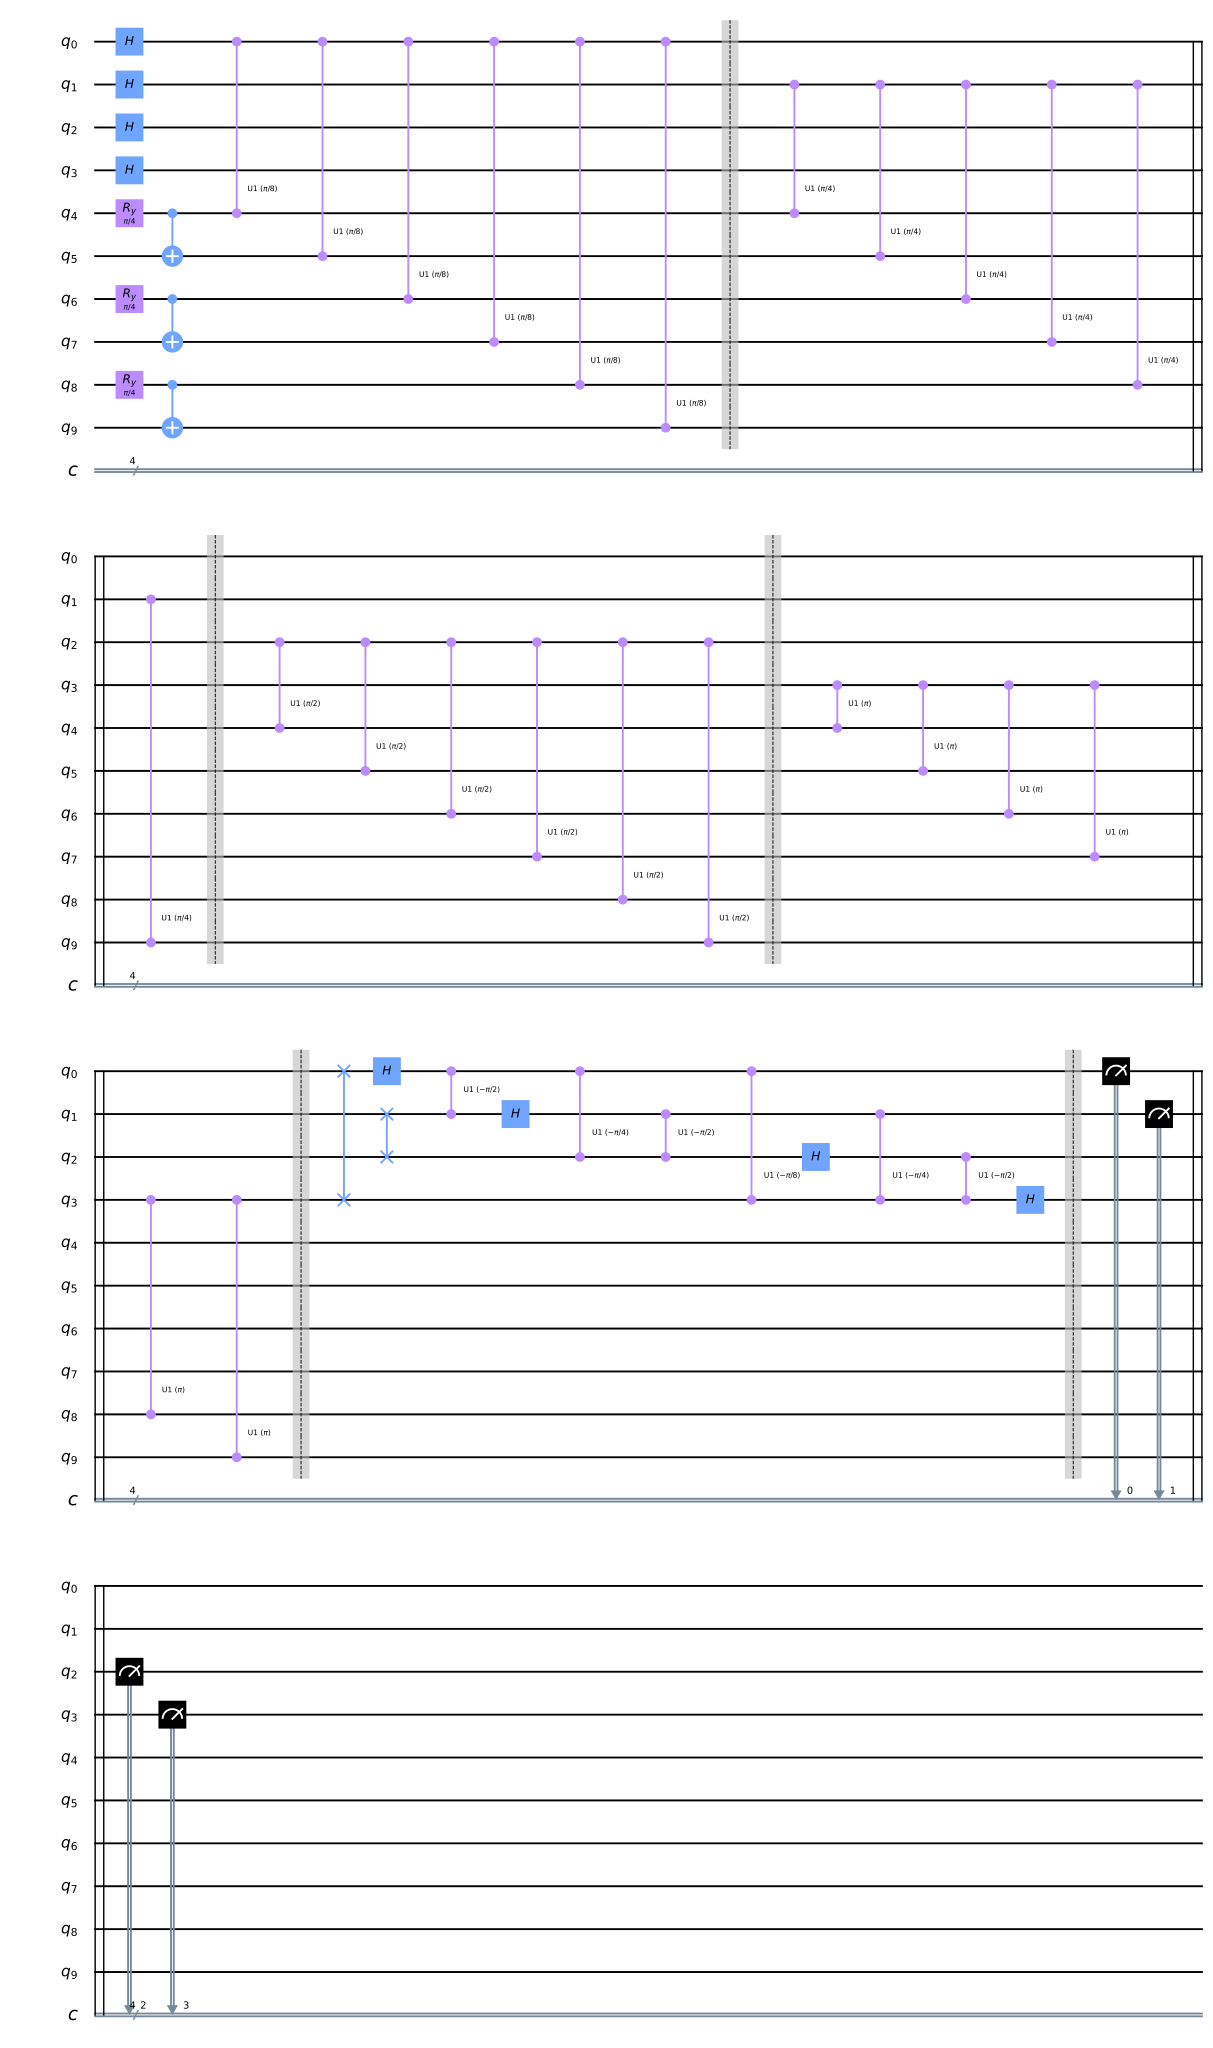

In [6]:
# Do the inverse QFT:
qft_dagger(qpe, nr)

# measure 
qpe.barrier()
    
for n in range(nr):
    qpe.measure(n,n)

qpe.draw('mpl')   

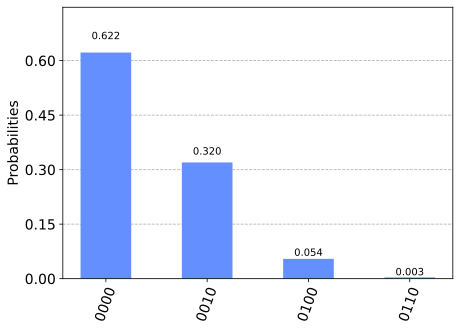

In [7]:
# Running the code !
backend = Aer.get_backend('qasm_simulator')
shots = 100000
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)
